# **Importing Libraries**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e47dc602508b3f5dac807b9ad94c92d78ee9116bef03a616f0e45afd15ac5565
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, exp

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("diabetes_modelling") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

<SparkContext master=local appName=diabetes_modelling>

In [ ]:
spark_df=spark.read.csv("/content/sample_data/diabetes_prediction_dataset.csv",header=True,inferSchema=True,sep=",")
spark_df.cache()

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int]

In [ ]:
spark_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
spark_df.show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



In [ ]:
spark_df.count()

100000

In [ ]:
len(spark_df.columns)

9

In [ ]:
spark_df.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  NULL|41.88585600000013|           0.07485|           0.03942|           NULL|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  NULL|22.51683987161704|0.2631504702289171|0.1945930169980986|           NULL|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

In [ ]:
spark_df.describe("blood_glucose_level").show()

+-------+-------------------+
|summary|blood_glucose_level|
+-------+-------------------+
|  count|             100000|
|   mean|          138.05806|
| stddev|  40.70813604870383|
|    min|                 80|
|    max|                300|
+-------+-------------------+



In [ ]:
spark_df.select("blood_glucose_level").show(5)

+-------------------+
|blood_glucose_level|
+-------------------+
|                140|
|                 80|
|                158|
|                155|
|                155|
+-------------------+
only showing top 5 rows



In [ ]:
spark_df.dropDuplicates().show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|21.0|           0|            0|          never|27.32|        5.8|                126|       0|
|  Male|26.0|           0|            0|          never|27.32|        6.6|                100|       0|
|Female|49.0|           0|            0|          never| 21.7|        5.8|                158|       0|
|Female|24.0|           0|            0|         former|20.47|        4.8|                100|       0|
|Female|53.0|           0|            0|          never| 31.4|        5.7|                 85|       0|
|Female|74.0|           0|            0|         former| 40.5|        3.5|                160|       0|
|  Male|76.0|           0|            0|         former|27.76|  

In [ ]:
spark_df.distinct().count()

96146

In [ ]:
spark_df.crosstab("age","blood_glucose_level").show()

+-----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|age_blood_glucose_level|100|126|130|140|145|155|158|159|160|200|220|240|260|280|300| 80| 85| 90|
+-----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|                    1.0| 11|  5|  6|  8|  3|  8|  4|  8|  2|  5|  0|  0|  0|  0|  0|  6| 11|  6|
|                   0.32|  5|  9|  8|  4|  8|  8|  4| 10|  7|  4|  0|  0|  0|  0|  0|  8|  6|  8|
|                   50.0| 92|110|119|123|128|102| 90|101|117|114|  7|  8| 14| 14| 13| 98| 93|112|
|                   75.0| 33| 53| 56| 50| 61| 44| 53| 61| 56| 59|  8| 13|  8| 21| 12| 42| 51| 40|
|                   22.0| 91| 94|102| 98| 99| 83|109| 96| 80| 81|  4|  4|  0|  2|  3| 99| 95| 97|
|                   65.0| 82| 87| 83| 98| 81| 74| 67| 86| 99| 78| 24| 14| 17| 28| 17| 52| 69| 78|
|                   38.0|109|114|126| 97|129|108|128|105| 86|109|  8|  5|  6|  5|  8|130|126| 99|
|                   

# **Outlier Detection**

In [ ]:
numericals=["age","bmi","HbA1c_level","blood_glucose_level"]
bounds={}

In [ ]:
for nc in numericals:

  quantiles = spark_df.approxQuantile(nc, [0.25,0.75], relativeError=0.05)
  IQR=quantiles[1]-quantiles[0]
  bounds[nc]=[
      quantiles[0]-1.5*IQR,
      quantiles[1]+1.5*IQR
  ]


In [ ]:
bounds

{'age': [-23.0, 105.0],
 'bmi': [16.765, 35.765],
 'HbA1c_level': [2.6999999999999993, 8.3],
 'blood_glucose_level': [13.0, 245.0]}

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from functools import reduce
spark_df.select(
    *[col(c) for c in numericals],
    *[
        F.when(
           col(c).between(bounds[c][0], bounds[c][1]),
           0
        ).otherwise(1).alias(c+"_out")
        for c in numericals
    ]
).where(reduce(lambda x, y: x | y,  (col(c+"_out") == 1 for c in numericals))).toPandas()

,age,bmi,HbA1c_level,blood_glucose_level,age_out,bmi_out,HbA1c_level_out,blood_glucose_level_out
0,54.0,54.70,6.0,100,0,1,0,0
1,78.0,36.05,5.0,130,0,1,0,0
2,40.0,36.38,6.0,90,0,1,0,0
3,4.0,13.99,4.0,140,0,1,0,0
4,5.0,15.10,5.8,85,0,1,0,0
...,...,...,...,...,...,...,...,...
16625,61.0,34.45,6.5,280,0,0,0,1
16626,47.0,45.15,4.0,126,0,1,0,0
16627,58.0,38.31,7.0,200,0,1,0,0
16628,32.0,37.71,6.1,126,0,1,0,0


In [ ]:
spark_df.describe("blood_glucose_level").show()

+-------+-------------------+
|summary|blood_glucose_level|
+-------+-------------------+
|  count|             100000|
|   mean|          138.05806|
| stddev|  40.70813604870383|
|    min|                 80|
|    max|                300|
+-------+-------------------+



In [ ]:
spark_df.describe("age").show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|           100000|
|   mean|41.88585600000013|
| stddev|22.51683987161704|
|    min|             0.08|
|    max|             80.0|
+-------+-----------------+



In [ ]:
spark_df.describe("bmi").show()

+-------+-----------------+
|summary|              bmi|
+-------+-----------------+
|  count|           100000|
|   mean|27.32076709999422|
| stddev|6.636783416648357|
|    min|            10.01|
|    max|            95.69|
+-------+-----------------+



In [ ]:
spark_df.describe("HbA1c_level").show()

+-------+------------------+
|summary|       HbA1c_level|
+-------+------------------+
|  count|            100000|
|   mean|5.5275069999983275|
| stddev|1.0706720918835468|
|    min|               3.5|
|    max|               9.0|
+-------+------------------+



# **Outlier Visualization**

In [ ]:
df=spark_df.toPandas()

Text(0.5, 1.0, 'HbA1c_level Boxplot')

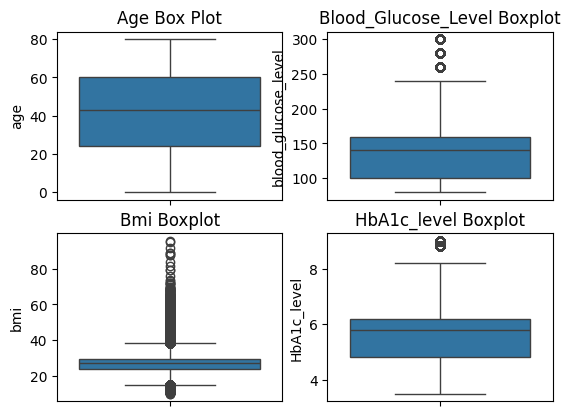

In [ ]:
plt.subplot(2,2,1)
sns.boxplot(df["age"])
plt.title("Age Box Plot")


plt.subplot(2,2,3)
sns.boxplot(df["bmi"])
plt.title("Bmi Boxplot")


plt.subplot(2,2,2)
sns.boxplot(df["blood_glucose_level"])
plt.title("Blood_Glucose_Level Boxplot")


plt.subplot(2,2,4)
sns.boxplot(df["HbA1c_level"])
plt.title("HbA1c_level Boxplot")

As it can be seen age doesn't have any outliers.Meanwhile, Bmi has the most one.

# **Age Feature Visualization**

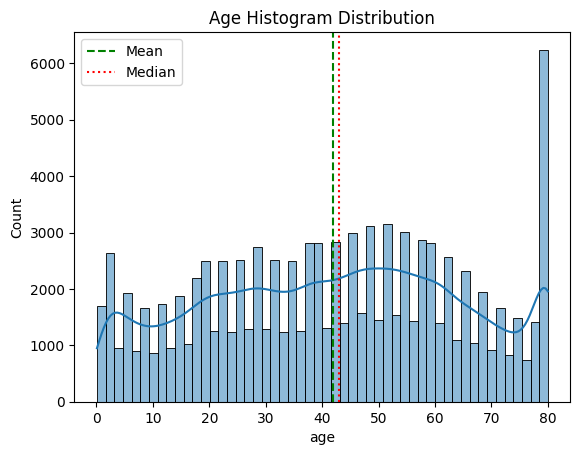

In [ ]:
sns.histplot(df["age"],kde=True)
plt.axvline(np.mean(df["age"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df["age"]),ls=":",c="r",label="Median")
plt.title("Age Histogram Distribution");
plt.legend()

Age feature has a balanced distribution which is close to normal distribution since mean and median values are close to each other.

Since old ages may increase some health problems, it is better to examine age feature by seperating some intervals such as kids,young adults,middle age adults and senior adults

In [ ]:
df["age_cut"]=pd.cut(x=df["age"],bins=[df["age"].min(),18,30,60,df["age"].max()],labels=["kids","young_adults","middle_age_adults","senior_adults"])

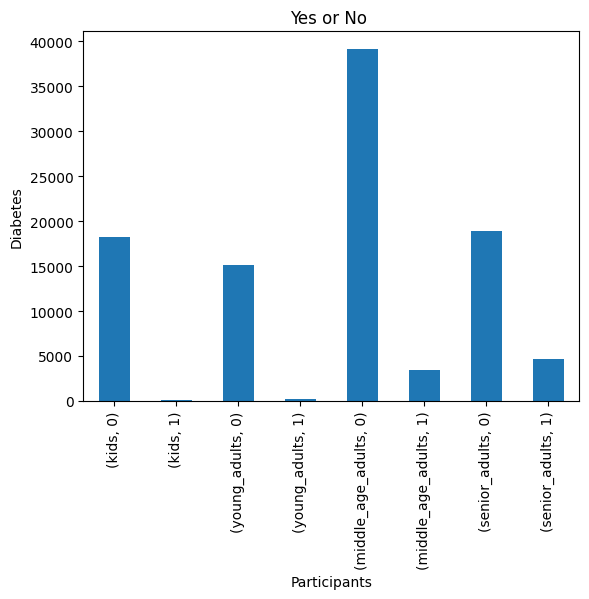

In [ ]:
df.groupby(df["age_cut"])["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

As it was guessed,age is a huge factor. Especially for kids and young adults, diabetes risk is significantly low but for seniors,the risk can not be ignored.

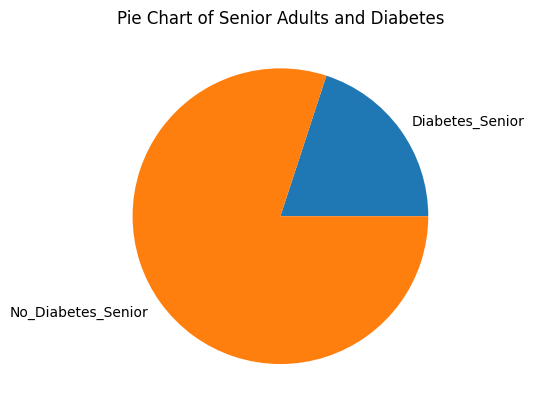

In [ ]:
Diabetes_Senior= ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)
No_Diabetes_Senior = ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 0)).value_counts().get(True, 0)

numbers = [Diabetes_Senior,No_Diabetes_Senior ]
labels = ['Diabetes_Senior', 'No_Diabetes_Senior']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Senior Adults and Diabetes")

plt.show()

Pie chart indicates that approximately %20 of senior in our dataset has diabetes.

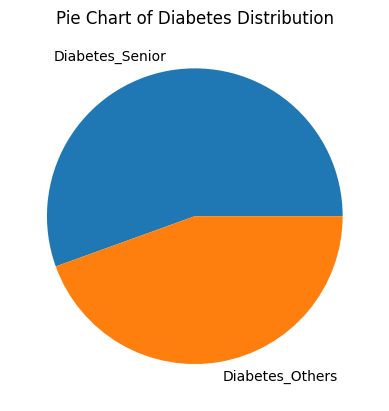

In [ ]:
Diabetes_Senior= ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)
Diabetes_Others = ((df['age_cut'] != 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)

numbers = [Diabetes_Senior,Diabetes_Others]
labels = ['Diabetes_Senior', 'Diabetes_Others']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Diabetes Distribution")

plt.show()

In [ ]:
df[df["age"].between(50,60)]["diabetes"].value_counts()

diabetes
0    14214
1     2072
Name: count, dtype: int64

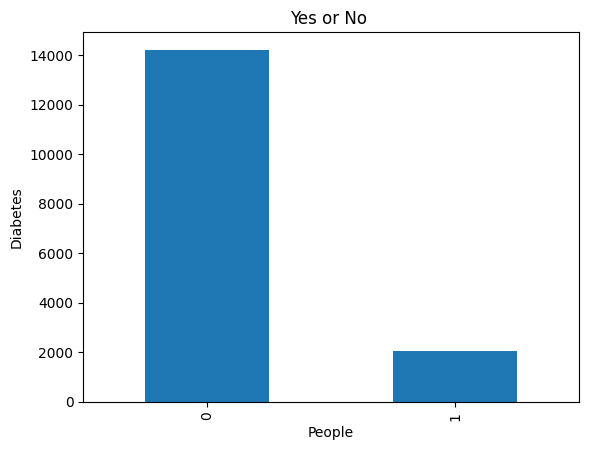

In [ ]:
df[df["age"].between(50,60)]["diabetes"].value_counts().plot(kind="bar")
plt.xlabel('People')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [ ]:
df.groupby("age_cut")["diabetes"].value_counts()

age_cut            diabetes
kids               0           18272
                   1              92
young_adults       0           15124
                   1             209
middle_age_adults  0           39155
                   1            3480
senior_adults      0           18913
                   1            4719
Name: count, dtype: int64

<Axes: xlabel='diabetes'>

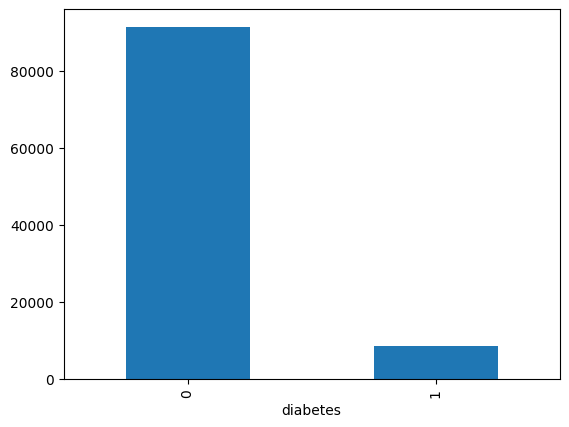

In [ ]:
df["diabetes"].value_counts().plot(kind="bar")

In [ ]:
df["diabetes"].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

From the barplot and number comparison in different age intervals, it is clear that 50+ years old people have significantly higher risk and those people are responsible for %80 of cases.

In [ ]:
df[df["bmi"]>25]["diabetes"].value_counts()

diabetes
0    61619
1     7569
Name: count, dtype: int64

In [ ]:
df[df["bmi"]<25]["diabetes"].value_counts()

diabetes
0    29786
1      927
Name: count, dtype: int64

In [ ]:
df["bmi_cut"]=pd.cut(x=df["bmi"],bins=[df["bmi"].min()-1,18.5,25,30,df["bmi"].max()],labels=["under_weight","normal_weight","overweight","obese"])

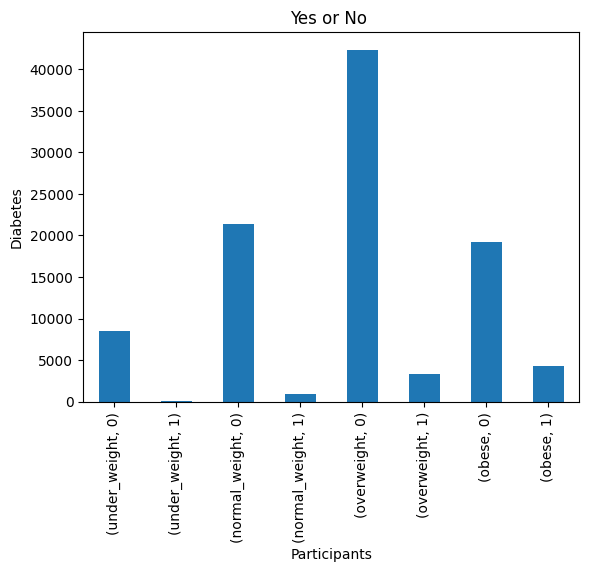

In [ ]:
df.groupby(df["bmi_cut"])["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [ ]:
for i in df["bmi_cut"].unique():

  print(i,df[df["bmi_cut"]==i]["diabetes"].value_counts()[1]/(df[df["bmi_cut"]==i]["diabetes"].value_counts()[0]+df[df["bmi_cut"]==i]["diabetes"].value_counts()[1]))

overweight 0.07301170550268023
normal_weight 0.03889462114754834
obese 0.1802154750244858
under_weight 0.0075108555333881


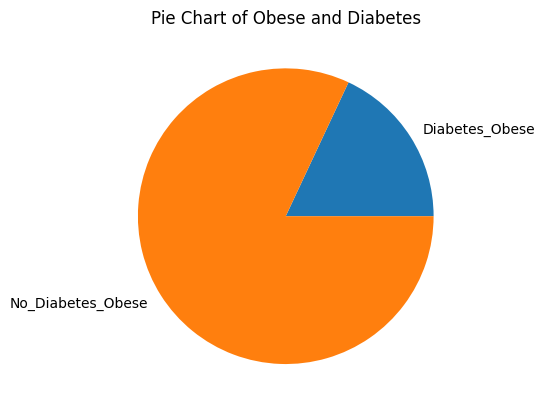

In [ ]:
Diabetes_Obese= ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)
No_Diabetes_Obese = ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 0)).value_counts().get(True, 0)

numbers = [Diabetes_Obese,No_Diabetes_Obese ]
labels = ['Diabetes_Obese', 'No_Diabetes_Obese']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Obese and Diabetes")

plt.show()

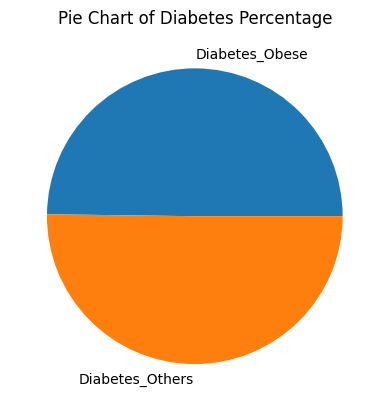

In [ ]:
Diabetes_Obese= ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)
Diabetes_Others = ((df['bmi_cut'] != 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)

numbers = [Diabetes_Obese,Diabetes_Others ]
labels = ['Diabetes_Obese', 'Diabetes_Others']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Diabetes Percentage")

plt.show()

# **New Feature Creation**

In [ ]:
spark_df_new= spark_df.withColumn("High_Risk_Age", when(spark_df.age>50, 1).otherwise(0))


Since age feature has ordinal relationship,it is better to convert it into categorical binary feature

In [ ]:
spark_df_new.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+-------------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|High_Risk_Age|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+-------------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|            1|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|            1|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|            0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|            0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|            1|
|Female|20.0|           0|            0|          never|

In [ ]:
spark_df_new=spark_df_new.drop("age")

In [ ]:
spark_df_new= spark_df_new.withColumn("High_Risk_Bmi", when(spark_df.bmi>29.99, 1).otherwise(0))

From earlier analysises, it was found that people who has over 30 bmi are account for %50 diabetes cases. Making this feature as binary is also better.

In [ ]:
spark_df_new.show()

+------+------------+-------------+---------------+-----+-----------+-------------------+--------+-------------+-------------+
|gender|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|High_Risk_Age|High_Risk_Bmi|
+------+------------+-------------+---------------+-----+-----------+-------------------+--------+-------------+-------------+
|Female|           0|            1|          never|25.19|        6.6|                140|       0|            1|            0|
|Female|           0|            0|        No Info|27.32|        6.6|                 80|       0|            1|            0|
|  Male|           0|            0|          never|27.32|        5.7|                158|       0|            0|            0|
|Female|           0|            0|        current|23.45|        5.0|                155|       0|            0|            0|
|  Male|           1|            1|        current|20.14|        4.8|                155|       0|            1

In [ ]:
spark_df_new=spark_df_new.drop("bmi")

# **Missing Value Control**

In [ ]:
for colu in spark_df_new.columns:
  print(colu,":",spark_df_new.filter(spark_df_new[colu].isNull()).count())


gender : 0
hypertension : 0
heart_disease : 0
smoking_history : 0
HbA1c_level : 0
blood_glucose_level : 0
diabetes : 0
High_Risk_Age : 0
High_Risk_Bmi : 0


# **Outlier Handling**

In [ ]:
numericals.remove("age")

In [ ]:
numericals.remove("bmi")

In [ ]:
spark_df_new=spark_df_new.select(
    *[col(c) for c in spark_df_new.columns],
    *[
        F.when(
           col(c)<bounds[c][0],
           bounds[c][0]
        ).when(col(c)>bounds[c][1],
           bounds[c][1]). otherwise(col(c)).alias(c+"_new")
        for c in numericals])

In [ ]:
spark_df_new.show()

+------+------------+-------------+---------------+-----------+-------------------+--------+-------------+-------------+---------------+-----------------------+
|gender|hypertension|heart_disease|smoking_history|HbA1c_level|blood_glucose_level|diabetes|High_Risk_Age|High_Risk_Bmi|HbA1c_level_new|blood_glucose_level_new|
+------+------------+-------------+---------------+-----------+-------------------+--------+-------------+-------------+---------------+-----------------------+
|Female|           0|            1|          never|        6.6|                140|       0|            1|            0|            6.6|                  140.0|
|Female|           0|            0|        No Info|        6.6|                 80|       0|            1|            0|            6.6|                   80.0|
|  Male|           0|            0|          never|        5.7|                158|       0|            0|            0|            5.7|                  158.0|
|Female|           0|            0

Since we created columns that don't have outlier values,we don't need previous ones.

In [ ]:
spark_df_new=spark_df_new.drop("blood_glucose_level","HbA1c_level")

In [ ]:
spark_df_new.show()

+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|High_Risk_Age|High_Risk_Bmi|HbA1c_level_new|blood_glucose_level_new|
+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+
|Female|           0|            1|          never|       0|            1|            0|            6.6|                  140.0|
|Female|           0|            0|        No Info|       0|            1|            0|            6.6|                   80.0|
|  Male|           0|            0|          never|       0|            0|            0|            5.7|                  158.0|
|Female|           0|            0|        current|       0|            0|            0|            5.0|                  155.0|
|  Male|           1|            1|        current|       0|            1|            0|         

In [ ]:
df_new=spark_df_new.toPandas()

# **Boxplot after Outlier Handling**

Text(0.5, 1.0, 'HbA1c_level Boxplot')

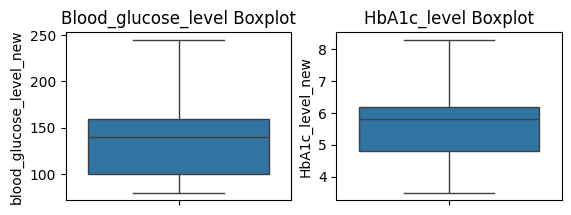

In [ ]:

plt.subplot(2,2,1)
sns.boxplot(df_new["blood_glucose_level_new"])
plt.title("Blood_glucose_level Boxplot")



plt.subplot(2,2,2)
sns.boxplot(df_new["HbA1c_level_new"])
plt.title("HbA1c_level Boxplot")

As it can be seen, outlier treatment worked

In [ ]:
for colu in spark_df_new.columns:
  print(colu,":",spark_df_new.filter(spark_df_new[colu].isNull()).count())

gender : 0
hypertension : 0
heart_disease : 0
smoking_history : 0
diabetes : 0
High_Risk_Age : 0
High_Risk_Bmi : 0
HbA1c_level_new : 0
blood_glucose_level_new : 0


In [ ]:
new_numericals=[]
for i in numericals:
  new_numericals.append(i+"_new")

In [ ]:
new_numericals

['HbA1c_level_new', 'blood_glucose_level_new']

# **Numerical Values Correlation**

<Axes: >

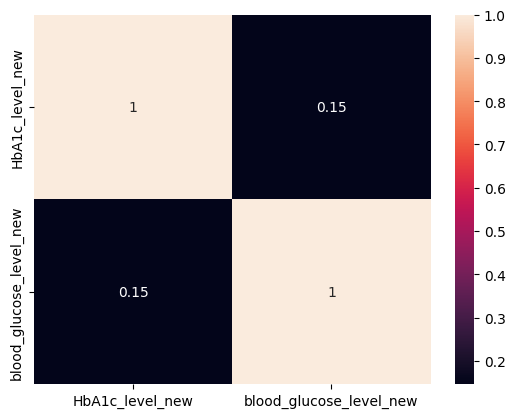

In [ ]:

sns.heatmap(df_new[new_numericals].corr(),annot=True)

There is no strong correlation between numerical values

# **Working on Another Features**

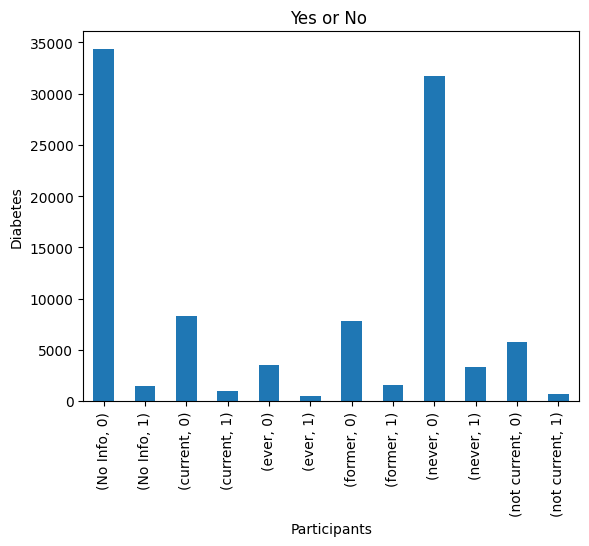

In [ ]:
df_new.groupby("smoking_history")["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [ ]:
df["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

Smoking_History feature has No Info type variable.To find which variable is best to replace that variable, it is better to look its relationship with dependent one.

In [ ]:
df_new[df_new["smoking_history"]=="No Info"]["diabetes"].value_counts()

diabetes
0    34362
1     1454
Name: count, dtype: int64

In [ ]:
df_new["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [ ]:
for i in df["smoking_history"].unique():

  print(i,df[df["smoking_history"]==i]["diabetes"].value_counts()[1]/(df[df["smoking_history"]==i]["diabetes"].value_counts()[0]+df[df["smoking_history"]==i]["diabetes"].value_counts()[1]))

never 0.09534121669753526
No Info 0.040596381505472415
current 0.10208916648718501
former 0.17001710863986313
ever 0.11788211788211789
not current 0.10702652396463472


As it can be clearly seen, there is no significant difference between variables about relationship with dependent variable

In [ ]:
for i in df_new["smoking_history"].unique():
  print(i,df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[1]/(df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[0]+df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[1]))


never 0.09129505627582277
No Info 0.03356041992405629
current 0.08959724316174887
former 0.14317792985457656
ever 0.10464535464535464
not current 0.07584923220102373


In [ ]:
for i in df_new["smoking_history"].unique():
  print(i,df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[1]/(df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[0]+df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[1]))

never 0.031258013962102864
No Info 0.02577060531605986
current 0.04404479862158087
former 0.09709153122326775
ever 0.07817182817182818
not current 0.04529238405459904


After looking its relationship with other categorical independent variables, it can be stated as there is no strong relationship between them. To replace that value, using the mode is the best choice.

In [ ]:
spark_df_new=spark_df_new.replace("No Info", "never")

In [ ]:
spark_df_new.show()

+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|High_Risk_Age|High_Risk_Bmi|HbA1c_level_new|blood_glucose_level_new|
+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+
|Female|           0|            1|          never|       0|            1|            0|            6.6|                  140.0|
|Female|           0|            0|          never|       0|            1|            0|            6.6|                   80.0|
|  Male|           0|            0|          never|       0|            0|            0|            5.7|                  158.0|
|Female|           0|            0|        current|       0|            0|            0|            5.0|                  155.0|
|  Male|           1|            1|        current|       0|            1|            0|         

In [ ]:
spark_df_new.select("smoking_history").distinct().count()

5

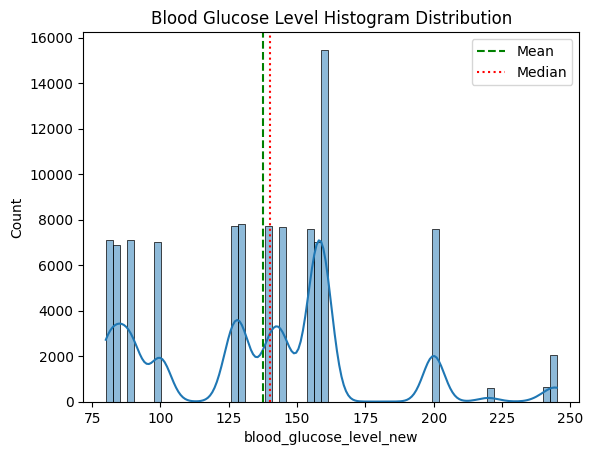

In [ ]:
sns.histplot(df_new["blood_glucose_level_new"],kde=True)
plt.axvline(np.mean(df_new["blood_glucose_level_new"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df_new["blood_glucose_level_new"]),ls=":",c="r",label="Median")
plt.title("Blood Glucose Level Histogram Distribution");
plt.legend()

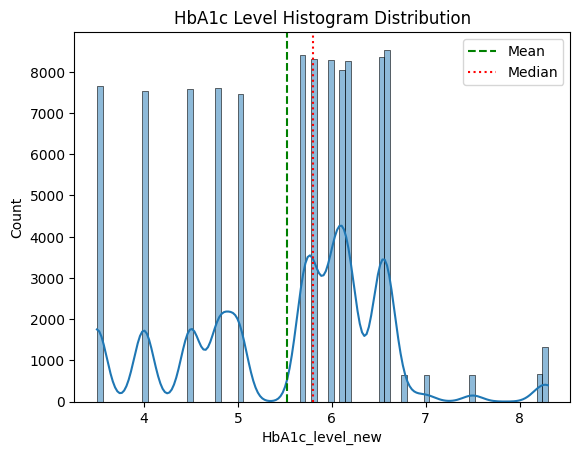

In [ ]:
sns.histplot(df_new["HbA1c_level_new"],kde=True)
plt.axvline(np.mean(df_new["HbA1c_level_new"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df_new["HbA1c_level_new"]),ls=":",c="r",label="Median")
plt.title("HbA1c Level Histogram Distribution");
plt.legend()

# **StringIndex**

In [ ]:
from pyspark.ml.feature import StringIndexer
stringIndexer=StringIndexer(inputCol="diabetes",outputCol="label")
spark_df_ind=stringIndexer.fit(spark_df_new).transform(spark_df_new)

In [ ]:
spark_df_ind.dtypes

[('gender', 'string'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('smoking_history', 'string'),
 ('diabetes', 'int'),
 ('High_Risk_Age', 'int'),
 ('High_Risk_Bmi', 'int'),
 ('HbA1c_level_new', 'double'),
 ('blood_glucose_level_new', 'double'),
 ('label', 'double')]

In [ ]:
spark_df_ind=spark_df_ind.withColumn("label",spark_df_ind["label"].cast("integer"))

In [ ]:
spark_df_ind.dtypes

[('gender', 'string'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('smoking_history', 'string'),
 ('diabetes', 'int'),
 ('High_Risk_Age', 'int'),
 ('High_Risk_Bmi', 'int'),
 ('HbA1c_level_new', 'double'),
 ('blood_glucose_level_new', 'double'),
 ('label', 'int')]

In [ ]:
spark_df_ind.show()

+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+-----+
|gender|hypertension|heart_disease|smoking_history|diabetes|High_Risk_Age|High_Risk_Bmi|HbA1c_level_new|blood_glucose_level_new|label|
+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+-----+
|Female|           0|            1|          never|       0|            1|            0|            6.6|                  140.0|    0|
|Female|           0|            0|          never|       0|            1|            0|            6.6|                   80.0|    0|
|  Male|           0|            0|          never|       0|            0|            0|            5.7|                  158.0|    0|
|Female|           0|            0|        current|       0|            0|            0|            5.0|                  155.0|    0|
|  Male|           1|            1|        current|    

In [ ]:
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(spark_df_ind) for column in list(set(spark_df_ind.columns)-set(new_numericals)-set(["label"]))]


pipeline = Pipeline(stages=indexers)
spark_df_ind = pipeline.fit(spark_df_ind).transform(spark_df_ind)

spark_df_ind.show()

+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+-----+------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|High_Risk_Age|High_Risk_Bmi|HbA1c_level_new|blood_glucose_level_new|label|gender_index|smoking_history_index|High_Risk_Age_index|heart_disease_index|hypertension_index|High_Risk_Bmi_index|diabetes_index|
+------+------------+-------------+---------------+--------+-------------+-------------+---------------+-----------------------+-----+------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------+
|Female|           0|            1|          never|       0|            1|            0|            6.6|                  140.0|    0|         0.0|                  0.0|                1.0|                1.0

In [ ]:
non_numericals=list(set(spark_df_new.columns)-set(new_numericals))

In [ ]:
non_numericals

['gender',
 'smoking_history',
 'High_Risk_Age',
 'heart_disease',
 'hypertension',
 'High_Risk_Bmi',
 'diabetes']

In [ ]:
spark_df_ind=spark_df_ind.drop('smoking_history',
 'High_Risk_Age',"High_Risk_bmi",
 'diabetes',
 'hypertension',
 'heart_disease',
 'gender','diabetes','diabetes_index')

In [ ]:
spark_df_ind.show()

+---------------+-----------------------+-----+------------+---------------------+-------------------+-------------------+------------------+-------------------+
|HbA1c_level_new|blood_glucose_level_new|label|gender_index|smoking_history_index|High_Risk_Age_index|heart_disease_index|hypertension_index|High_Risk_Bmi_index|
+---------------+-----------------------+-----+------------+---------------------+-------------------+-------------------+------------------+-------------------+
|            6.6|                  140.0|    0|         0.0|                  0.0|                1.0|                1.0|               0.0|                0.0|
|            6.6|                   80.0|    0|         0.0|                  0.0|                1.0|                0.0|               0.0|                0.0|
|            5.7|                  158.0|    0|         1.0|                  0.0|                0.0|                0.0|               0.0|                0.0|
|            5.0|           

# **Vectorization**

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
vectorAssembler=VectorAssembler(inputCols=list(set(spark_df_ind.columns)-set(["label"])),outputCol="features")

In [ ]:
va_df=vectorAssembler.transform(spark_df_ind)

In [ ]:
final_df=va_df.select(["features","label"])

In [ ]:
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(8,[0,1,4,5],[1.0...|    0|
|(8,[1,4,5],[80.0,...|    0|
|(8,[1,2,4],[158.0...|    0|
|(8,[1,4,7],[155.0...|    0|
|[1.0,155.0,1.0,1....|    0|
|(8,[1,4],[85.0,6.6])|    0|
|(8,[1,4],[200.0,6...|    1|
|(8,[1,4,5],[85.0,...|    0|
|(8,[1,2,4,6],[145...|    0|
|(8,[1,4],[100.0,5...|    0|
|(8,[1,4,5],[85.0,...|    0|
|[0.0,100.0,0.0,0....|    0|
|[0.0,130.0,0.0,0....|    0|
|(8,[1,4,5],[200.0...|    0|
|(8,[1,4,5],[160.0...|    0|
|(8,[1,2,4,5],[126...|    0|
|(8,[1,2,4,6],[200...|    0|
|(8,[1,4],[158.0,5...|    0|
|(8,[1,4],[80.0,5.7])|    0|
|(8,[1,2,4,7],[159...|    0|
+--------------------+-----+
only showing top 20 rows



# **Train-Test Split**

In [ ]:
splits=final_df.randomSplit([0.7,0.3])
train_df=splits[0]
test_df=splits[1]

# **Model Training**

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
gbm=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")

In [ ]:
gbm_model=gbm.fit(train_df)

In [ ]:
y_pred=gbm_model.transform(test_df)

In [ ]:
ac=y_pred.select("label","prediction")

In [ ]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.9726205562595878

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator= gbm, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)

In [137]:
v_model = cv.fit(train_df)

In [138]:
y_pred = v_model.transform(test_df)
ac = y_pred.select("label","prediction")

In [140]:
evaluator.evaluate(y_pred)

0.9750312796542681